## Diving into Feature Engineering:
In this notebook I'll use the `feature_columns` method from tensorflow and use it to improove the performance of the predictions of the model. More specific, the following features:
 + Bucketized columns
 + Crossed columns
 + Embedding

Designing the correct features and rating the importance of every input is an important step in the design of a machine learning model. With these tools the training process gets faster executing times (if we are able to drop some inputs in exchange for crossed features with much more significance than other inputs), and better performance overall (lower variance). However, some features could induce the model to overfit the data, specially when the dataset is not long enough. 

In [83]:
# import important stuff:
import tensorflow as tf
import pandas as pd

from tensorflow import feature_column as fc
from tensorflow.keras import layers

# a library to plot the distribution of atts:
import seaborn as sea
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
# downloading the data
# !gsutil cp gs://cloud-training/mlongcp/v3.0_MLonGC/toy_data/housing_pre-proc_toy.csv /data
# This dataset (provided by google) already has been cleaned and wrangled.


df = pd.read_csv("data/housing_pre-proc_toy.csv")
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41,880,129,322,126,8.3252,452600,NEAR BAY
1,-122.22,37.86,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY
2,-122.24,37.85,52,1467,190,496,177,7.2574,352100,NEAR BAY
3,-122.25,37.85,52,1274,235,558,219,5.6431,341300,NEAR BAY
4,-122.25,37.85,52,1627,280,565,259,3.8462,342200,NEAR BAY


It's very important to explore the data, like get the distribution each column shows, creating relations between columns (later this will help when crossing some features), and identify which columns. It's time for some fancy plots.

In [84]:
# This method gives general info about each column:
df.describe()

# Some cols have higher std (standar deviation). This gives a basic idea of how the data is distributed, and (in certain manner) if its statisticly suficcient.


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,-121.501836,37.802288,30.088400,2522.734000,491.862400,1246.225200,458.122000,3.694312,170288.731200
std,1.015963,0.803090,13.878416,1988.411988,362.499497,925.075463,341.744308,1.859422,97550.278529
min,-124.300000,36.130000,2.000000,12.000000,4.000000,18.000000,2.000000,0.499900,22500.000000
25%,-122.200000,37.600000,18.000000,1420.750000,282.000000,718.000000,263.000000,2.357875,92950.000000
50%,-122.030000,37.800000,30.000000,2052.000000,402.000000,1030.500000,374.500000,3.262200,150800.000000
75%,-120.697500,37.960000,41.000000,3007.250000,581.250000,1488.250000,538.000000,4.662975,219650.000000
max,-118.910000,41.950000,52.000000,28258.000000,3864.000000,12203.000000,3701.000000,15.000100,500001.000000


In [85]:
# Set the theme:
sea.set_theme(palette="flare")

First lets see the distribution of the data from the **housing_median_age** column:

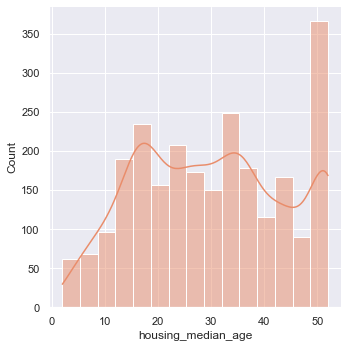

In [86]:
sea.displot(data = df, x = 'housing_median_age', kde = True)

It looks like a normal distribution with noticeable noise. There are buckets with more data than others. And more data on the last bucket in comparisson with the buckets close to the mean. This factors can cause overfitting, the model having bias over the ages that have more data in contrast with the less populated. 
Overall, we could say that (in most cases) a new house can be sold with a higher price than older houses. 

Next, some distributions with huge outliers:

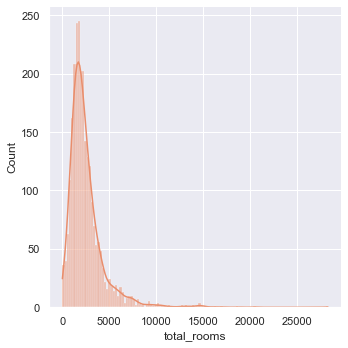

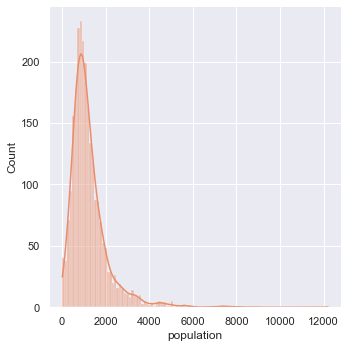

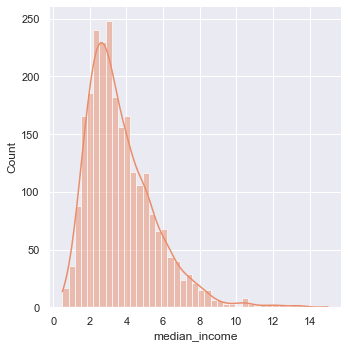

In [87]:
sea.displot(data = df, x = 'total_rooms', kde = True)
sea.displot(data = df, x = 'population', kde = True)
sea.displot(data = df, x = 'median_income', kde = True)

As noted by the quantiles in the **describe(  )** output, we can se that the max vaules of this columns are very high. Thus, the model, when computing the loss derivate, is very likely to overfit the data. Some kind of regularization should be implemented for training.

Now, the pandas' dataframe has to be converted to a tf.dataset to be used in training:

In [88]:
col_names = list(df.columns)
label_name = 'median_house_value'

# The numeric columns:
col_numerics = [
    'longitude', 'latitude', 'housing_median_age', 
    'total_rooms', 'total_bedrooms', 'population', 
    'households', 'median_income']

# There's only 1 categorical column:
col_string = 'ocean_proximity'

# Batch_size (to be used in the make_csv_dataset from tensorflow])
batch_size = 32

Now its time to create a tensorflow dataset (tf.data.Dataset) to be used in the training process. In this ocassion, the method used will be applying a function on every row (using the map function) to split the columns, thereby resulting in a pair of "inputs, label":

In [89]:
# This functions takes a row of the dataset (as a list) and split it into a (inputs, label) pair
def split_rows(row):
    label = row.pop(label_name)
    return row, label

# This function takes the name (or pattern) of the csv file were the data is.
# There are other methods to load a tensorflow dataset (like converting lists to tensors with tf.data.Dataset.from_tensor_slices())
# but with bigger datasets, its more convenient to use .make_csv_dataset() method because it can batch the dataset from the file and 
# prefetch batchs.

def trans_dataset(pattern, mode = 'eval', batch_size = 1):
    dataset = tf.data.experimental.make_csv_dataset(pattern, col_names)
    # tf.data.Dataset.from_tensor_slices(df[col_numerics]) z-- another way
    dataset = dataset.map(split_rows)           # 'map' method applies the function to every row, is like 'apply'

    if mode == 'train':
        dataset.shuffle(1000).repeat()

    return dataset

def df_to_dataset(dataframe, shuffle=True, batch_size=1):
    dataframe = dataframe.copy()
    labels = dataframe.pop('median_house_value')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [90]:
# Given the small size of the dataset (2500 rows) we can use the 'df' dataframe previously loaded:
# and then use this datasets in the model training-validation-test. 
train_ds, test_ds = train_test_split(df, test_size = 0.2)
train_ds, val_ds = train_test_split(train_ds, test_size = 0.2)

resultados = test_ds['median_house_value']
train_ds_ax = train_ds

# However, when the datasets are large enough, we can use the function trans_dataset():
# train_ds.to_csv("data/train_ds.csv", index = False)
test_ds.to_csv("data/test_ds.csv", index = False)
# val_ds.to_csv("data/val_ds.csv", index = False)

# train_ds = trans_dataset('data/train*', 'train')
# val_ds = trans_dataset('data/val*')

train_ds = df_to_dataset(train_ds)
val_ds = df_to_dataset(val_ds)
test_ds = df_to_dataset(test_ds)

**Models**: 
Two NN models will be tested. The first one will be a baseline model, with no change on the inputs (they'll go entirely as features). The second one will integrate more features and it'll showcase corss, buckets and other types of features. 

_Here goes nothing (model 1 ,no-Features)_

In [91]:
# ALl numeric inputs will be normalized, this is the only modification to the inputs in this baseline model.
def get_scaler(data):
    def mixmax(x):
        mini = train_ds[data].min()
        maxi = train_ds[data].max()
        return (x - mini) / (maxi - mini)
        return mixmax


feature_cols = []

for feature in col_numerics:
    scaler = get_scaler(feature)
    feature_cols.append(fc.numeric_column(feature, normalizer_fn=scaler))

In [92]:
# Dense tensor as input

inputs = {
    colname: layers.Input(name = colname, shape = (), dtype = 'float32')
    for colname in col_numerics
}

feature_cols = {
    colname: fc.numeric_column(colname, normalizer_fn=get_scaler(colname))
    for colname in col_numerics
}

nn = len(feature_cols)
print("Input dim: {}".format(str(nn)))

print(inputs.values())
dnn_inputs = layers.DenseFeatures(feature_cols.values())(inputs)
h1 = layers.Dense(32, activation = 'relu', name = 'h1')(dnn_inputs)
h2 = layers.Dense(16, activation = 'relu', name = 'h2')(h1)
output = layers.Dense(1, activation = 'linear', name = 'median_house_value')(h2)


base_model = tf.keras.models.Model(inputs, output)

base_model.compile(optimizer = 'adam',
                    loss = 'mse',
                    metrics = ['mse'])

## this model has no categorical features handling, so only the numeric
# features are being used

b_results = base_model.fit(train_ds, validation_data = val_ds, epochs = 5)

Input dim: 8
dict_values([<KerasTensor: shape=(None,) dtype=float32 (created by layer 'longitude')>, <KerasTensor: shape=(None,) dtype=float32 (created by layer 'latitude')>, <KerasTensor: shape=(None,) dtype=float32 (created by layer 'housing_median_age')>, <KerasTensor: shape=(None,) dtype=float32 (created by layer 'total_rooms')>, <KerasTensor: shape=(None,) dtype=float32 (created by layer 'total_bedrooms')>, <KerasTensor: shape=(None,) dtype=float32 (created by layer 'population')>, <KerasTensor: shape=(None,) dtype=float32 (created by layer 'households')>, <KerasTensor: shape=(None,) dtype=float32 (created by layer 'median_income')>])
Epoch 1/5


c:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:559: UserWarning: Input dict contained keys ['ocean_proximity'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1600/1600 [==============================] - 8s 4ms/step - loss: 18817474560.0000 - mse: 18817474560.0000 - val_loss: 17172684800.0000 - val_mse: 17172684800.0000
Epoch 2/5
1600/1600 [==============================] - 6s 4ms/step - loss: 14524832768.0000 - mse: 14524832768.0000 - val_loss: 15330031616.0000 - val_mse: 15330031616.0000
Epoch 3/5
1600/1600 [==============================] - 6s 4ms/step - loss: 13509862400.0000 - mse: 13509862400.0000 - val_loss: 13876905984.0000 - val_mse: 13876905984.0000
Epoch 4/5
1600/1600 [==============================] - 8s 5ms/step - loss: 12473369600.0000 - mse: 12473369600.0000 - val_loss: 12601374720.0000 - val_mse: 12601374720.0000
Epoch 5/5
1600/1600 [==============================] - 8s 5ms/step - loss: 11107679232.0000 - mse: 11107679232.0000 - val_loss: 11641956352.0000 - val_mse: 11641956352.0000


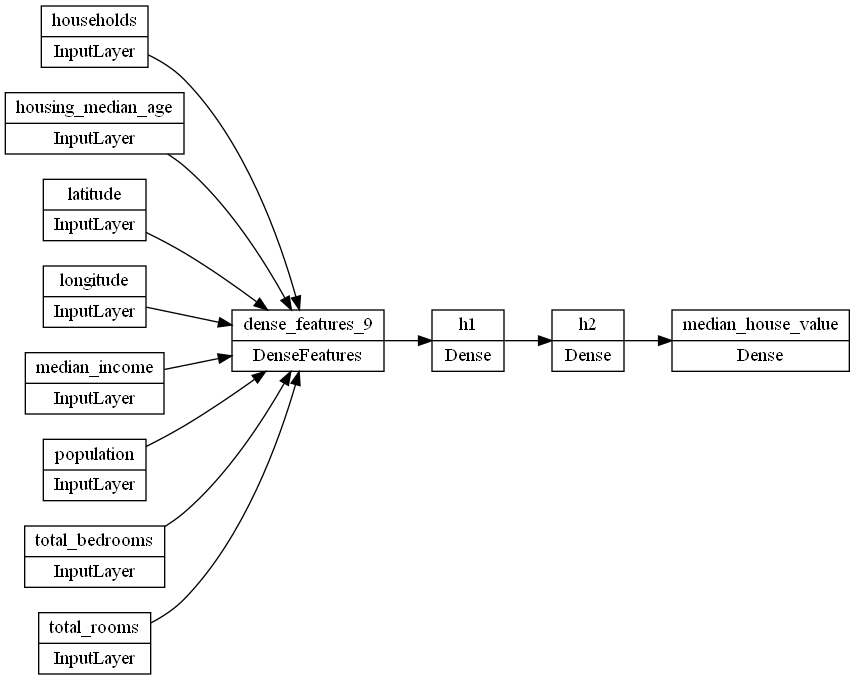

In [93]:
# show the model
tf.keras.utils.plot_model(base_model, 'base_model.png', show_shapes=False, rankdir='LR')

#### Now the model with more features:  
First define the vanilla numeric and string columns

In [94]:
def roomsxper(params):
    room, pop = params
    return room / pop

dict_values([<KerasTensor: shape=(None,) dtype=float32 (created by layer 'longitude')>, <KerasTensor: shape=(None,) dtype=float32 (created by layer 'latitude')>, <KerasTensor: shape=(None,) dtype=float32 (created by layer 'housing_median_age')>, <KerasTensor: shape=(None,) dtype=float32 (created by layer 'total_rooms')>, <KerasTensor: shape=(None,) dtype=float32 (created by layer 'total_bedrooms')>, <KerasTensor: shape=(None,) dtype=float32 (created by layer 'population')>, <KerasTensor: shape=(None,) dtype=float32 (created by layer 'households')>, <KerasTensor: shape=(None,) dtype=float32 (created by layer 'median_income')>])


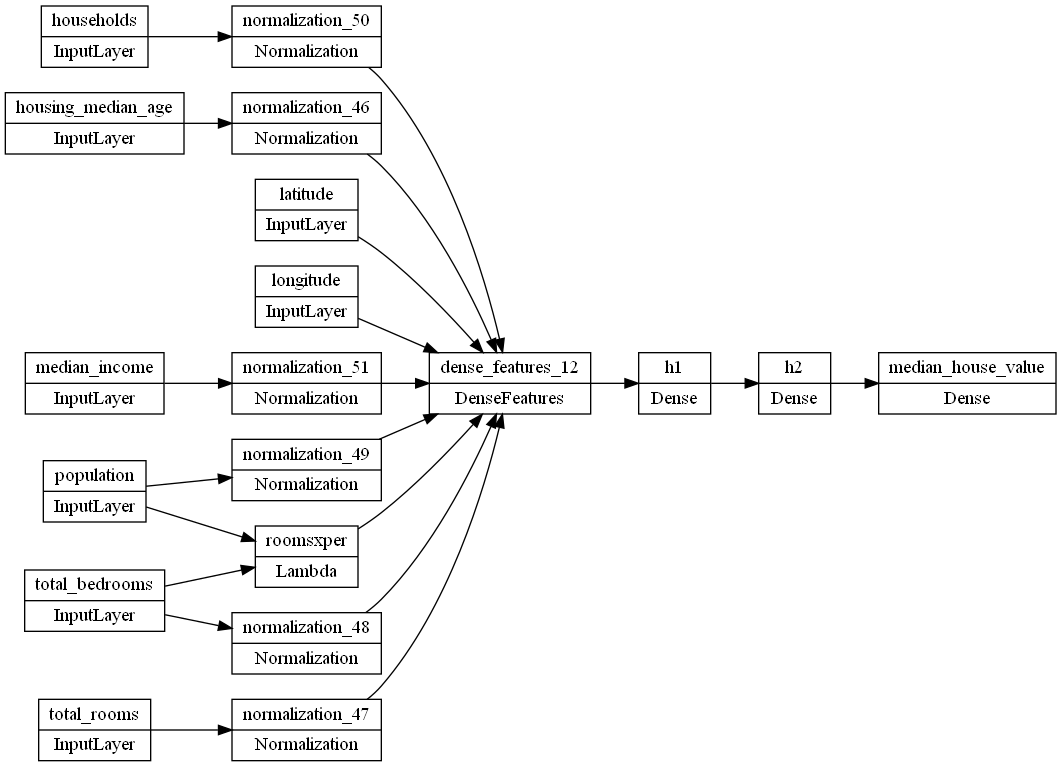

In [120]:
 # numeric values that'll be used on feature cols:
numerics_fc = [
'housing_median_age', 
'total_rooms', 'total_bedrooms', 'population', 
'households', 'median_income']

col_numerics_2 = col_numerics  # A really good input pipeline

col_string_2 = [
    'ocean_proximity'
]

# The feature columns (before feature eng.):
inputs = {
    col_name: layers.Input(name = col_name, shape = (), dtype= 'float32')
    for col_name in col_numerics_2
}

# inputs.update({
#     col_name: layers.Input(name = col_name, shape = (), dtype= 'string')
#     for col_name in col_string_2
# })

transformed = inputs.copy()

# normalizing numeric features:
for perro in col_numerics_2:
    if perro not in ['longitude', 'latitude']:
        layer = layers.Normalization(axis = None)
        layer.adapt(train_ds_ax[perro])
        transformed[perro] = layer(inputs[perro])

feature_cols = {
    col_name: fc.numeric_column(col_name)
    for col_name in numerics_fc
}

# now rooms x person (an aux function is needed):
transformed['roomsxper'] = layers.Lambda(
    roomsxper,
    name = 'roomsxper')([
        inputs['total_bedrooms'],
        inputs['population']]
    )

feature_cols['roomsxper'] = fc.numeric_column('roomsxper')

# Second, given the distribution of the "population" column, 
# a bucketized feature could be useful

# locatio
# feature_cols['location'] = fc.embedding_column(fc.crossed_column(['latitude', 'longitude'], 100), 1000) 

# One-hot OCEAN PROXIMITY:
# vocab = df[col_string].unique()

# one_hot_OP = fc.categorical_column_with_vocabulary_list(col_string, vocab)
# feature_cols['OceaProx'] = fc.indicator_column(one_hot_OP)

# now the odel:

print(inputs.values())
dnn_inputs = layers.DenseFeatures(feature_cols.values())(transformed)
h1 = layers.Dense(32, activation = 'relu', name = 'h1')(dnn_inputs)
h2 = layers.Dense(16, activation = 'relu', name = 'h2')(h1)
output = layers.Dense(1, activation = 'linear', name = 'median_house_value')(h2)

feat_model = tf.keras.models.Model(inputs, output)

feat_model.compile(optimizer = 'adam',
                    loss = 'mse',
                    metrics = ['mse'])

                    
# now te plot:
tf.keras.utils.plot_model(feat_model, 'featured_model.png', show_shapes=False, rankdir='LR')

In this case, the new features are:
+ Location (crossing latitude and longitude)
+ Population discretized (bucketized)
+ Rooms per person (number of rooms / population)
+ One-hot encoding Ocean proximity

Now, the training:

In [121]:
f_results = feat_model.fit(train_ds, validation_data= val_ds, epochs = 10)

Epoch 1/10


c:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:559: UserWarning: Input dict contained keys ['ocean_proximity'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1600/1600 [==============================] - 8s 4ms/step - loss: 38031831040.0000 - mse: 38031831040.0000 - val_loss: 37494403072.0000 - val_mse: 37494403072.0000
Epoch 2/10
1600/1600 [==============================] - 6s 4ms/step - loss: 34966155264.0000 - mse: 34966155264.0000 - val_loss: 32457043968.0000 - val_mse: 32457043968.0000
Epoch 3/10
1600/1600 [==============================] - 6s 4ms/step - loss: 27902386176.0000 - mse: 27902386176.0000 - val_loss: 24040157184.0000 - val_mse: 24040157184.0000
Epoch 4/10
1600/1600 [==============================] - 6s 4ms/step - loss: 19367391232.0000 - mse: 19367391232.0000 - val_loss: 15894781952.0000 - val_mse: 15894781952.0000
Epoch 5/10
1600/1600 [==============================] - 6s 4ms/step - loss: 12796001280.0000 - mse: 12796001280.0000 - val_loss: 10334597120.0000 - val_mse: 10334597120.0000
Epoch 6/10
1600/1600 [==============================] - 6s 4ms/step - loss: 9164525568.0000 - mse: 9164525568.0000 - val_loss: 7563823104.000

Now, it's time to compare the performance of each model.
First, the learning curves.

In [122]:
def show_curves(data1, data2):
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(nrows, ncols, 1)
    plt.plot(data1.history['mse'])
    plt.plot(data1.history['val_{}'.format('mse')])
    plt.title('Base model {}'.format('mse'))
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');  

    ax = fig.add_subplot(nrows, ncols, 2)
    plt.plot(data2.history['mse'])
    plt.plot(data2.history['val_{}'.format('mse')])
    plt.title('Featured model {}'.format('mse'))
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');  

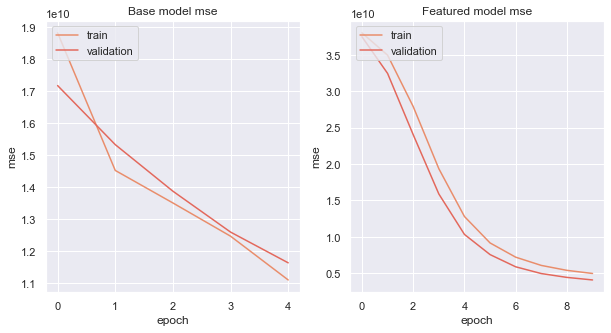

In [123]:
show_curves(b_results, f_results)

In [124]:
#basel_model.predict_on_batch(test_ds)
pred_base = base_model.predict(test_ds)
pred_featured = feat_model.predict(test_ds)

In [125]:
p_b = pred_base.round().tolist()
p_f = pred_featured.round().tolist()
restas = resultados.round().tolist()
for e in range(0, len(pred_base)):
    print(str(restas[e]) + " \t -- " + str(p_b[e][0]) + "\t" + str(p_f[e][0]))

print("MSE baseline: ", mean_squared_error(restas, p_b))
#            long   lat     age t_rooms t_bedrooms   pop     households median_income   ocean_proximity
# 47500:::: -119.79 36.73   52  112     28           193     40          1.975          INLAND      (ALTO)
# 131100::: -121.7  37.94   36  1710    320          861     300         2.8828         INLAND      (ALTO)
# 183700::: -122.13 37.7    43  3046    557          1333    544         3.4583         NEAR BAY    (BAJO)

152400 	 -- 145860.0	288054.0
173400 	 -- 148474.0	191292.0
108300 	 -- 75909.0	79264.0
103600 	 -- 126939.0	51309.0
87700 	 -- 162335.0	93063.0
206200 	 -- 134967.0	144630.0
111800 	 -- 128421.0	150972.0
91600 	 -- 145933.0	131162.0
177500 	 -- 161585.0	76403.0
222200 	 -- 173642.0	157203.0
137500 	 -- 228338.0	132897.0
165500 	 -- 214523.0	91050.0
127600 	 -- 217695.0	282932.0
66900 	 -- 157117.0	121230.0
89600 	 -- 103800.0	108609.0
262500 	 -- 314140.0	202631.0
151800 	 -- 151965.0	141639.0
111200 	 -- 169856.0	99869.0
113400 	 -- 208306.0	224062.0
100900 	 -- 82493.0	140580.0
133400 	 -- 164668.0	102873.0
116700 	 -- 137575.0	239085.0
130600 	 -- 138848.0	133390.0
225600 	 -- 339982.0	101938.0
90600 	 -- 178872.0	104674.0
461400 	 -- 293952.0	262236.0
103600 	 -- 162792.0	107300.0
118500 	 -- 112261.0	106383.0
126000 	 -- 118362.0	210434.0
46700 	 -- 150320.0	92436.0
87500 	 -- 135405.0	187763.0
367100 	 -- 100818.0	129683.0
120300 	 -- 139721.0	113829.0
143100 	 -- 165130.0	12858

In [126]:

err_featured = (resultados.array - np.array(pred_featured))**2
r_feat = tf.sqrt(err_featured.sum())/len(err_featured)

err_base = (resultados.array - np.array(pred_base))**2
r_base = tf.sqrt(err_base.sum())/len(err_base)

In [127]:
print(r_base.numpy())
print(r_feat.numpy())

118083.04905215737
124341.40546141822
